x_train.shape=(60000, 28, 28), y_train.shape=(60000,)
x_test.shape=(10000, 28, 28), y_test.shape=(10000,)
x_train.shape=(60000, 28, 28, 1)
x_test.shape=(10000, 28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 36)        14436     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 36)         0         
 2D)                                                             
                                                                 
 dropout (Dropout

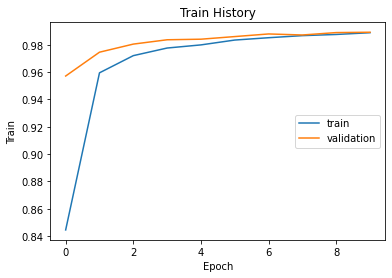

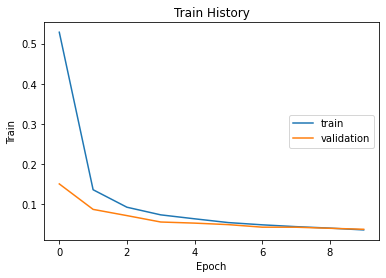

(10000, 10)


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,976,0,0,0,0,0,0,2,2,0
1,0,1131,2,0,0,0,1,1,0,0
2,1,2,1023,0,0,0,0,5,1,0
3,0,0,1,1002,0,6,0,1,0,0
4,0,0,0,0,976,0,1,1,1,3
5,1,0,0,6,0,883,1,1,0,0
6,2,2,1,0,2,4,946,0,1,0
7,0,2,1,3,0,0,0,1021,1,0
8,2,0,3,2,1,1,1,4,957,3


In [1]:
# 使用1.x版本的tensorflow
#%tensorflow_version 1.x
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

# 讀取mnist資料 
# x_train為60000筆訓練資料,每一筆資料為28x28的灰階手寫數字
# y_train為60000筆資料的正確數字(0,1,2,3,4,5,6,7,8,9)
# x_test為10000筆訓練資料,每一筆資料為28x28的灰階手寫數字
# y_test為10000筆資料的正確數字(0,1,2,3,4,5,6,7,8,9)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))


# 接著我們必須將x_train及x_test dataset由原本三維轉為四維矩陣以符合CNN的需求
# 這是因為RGB圖片的格式為為width, height, channels，加上ID數維度為4。
# MNIST圖片為灰階因此其channel為1，轉換後的shape為(ID, width, height, channel)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
print("x_train.shape={}".format(x_train.shape))
print("x_test.shape={}".format(x_test.shape))


# 接下來將dataset的特徵值進行標準化，方法是除以255（因為圖像的像素點介於0~255之間）
# 可讓所有的特徵值介於0與1之間。除了可提昇模型預測的準確度，梯度運算時也能更快收斂。

x_train = x_train / 255
x_test = x_test / 255


# 手寫數字結果如果採用原來的1, 2, 3....在演算法中，會以為2是1的兩倍大，3是1的三倍大，其實並沒有這個意義
# 因此會採用Onehot encoding，將彼此間不相關且非有序的categories轉換為連續性且是有序數值。
# 舉例來說，原本y_train[0]=5，經過onehot encoding會變成[0,0,0,0,0,1,0,0,0,0]

y_train = np_utils.to_categorical(y_train)
y_test_categories = y_test
y_test = np_utils.to_categorical(y_test)

# CNN模型建置
# filter代表過濾器的數量, kernel_size代表filter的大小
# padding: filter遇到邊緣的處理模式('same'為補0, 'valid'為忽略)

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=36, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()     


# 模型編譯
# loss:損失函數 optimizer:學習函數(梯度縮減的方式) metrics:評估模型好壞的方式(accuracy=正確率)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 模型訓練
# x:訓練資料 y:訓練資料的答案 validation_split:訓練資料的多少百分比要拿來驗證 validation_data:驗證資料 
# epochs:模型訓練次數 

train_history=model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), validation_split=0.2, epochs=10, batch_size=300, verbose=2)


# 模型評估

scores = model.evaluate(x_test, y_test)
print("模型正確率為：{}".format(scores[1]))


#繪製正確性與損失立歷史圖
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('Train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

# Confusion Matrix混淆矩陣
import pandas as pd
prediction = model.predict(x_test)
prediction_classes_x=np.argmax(prediction,axis=1)
print(y_test.shape)
pd.crosstab(y_test_categories, prediction_classes_x, rownames=['label'], colnames=['predict'])


# New Section